<a href="https://colab.research.google.com/github/tsanoop887-hash/credit-default-imbalance-guide/blob/main/Credit_default_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import optuna
import warnings
warnings.filterwarnings("ignore")

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
)
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
print("📂 Upload the file: default of credit card clients.xls")
uploaded = files.upload()


📂 Upload the file: default of credit card clients.xls


Saving default+of+credit+card+clients.zip to default+of+credit+card+clients.zip


In [9]:
import zipfile

filename = list(uploaded.keys())[0]

# Unzip the file if it's a zip archive
if filename.endswith('.zip'):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')
    # Assuming the Excel file has the same base name as the zip file without '+'.
    # Or, list files in the zip and pick the excel file.
    # For this specific case, the original file name was 'default of credit card clients.xls'
    # The uploaded filename was 'default+of+credit+card+clients.zip'
    # Let's assume the extracted file will be 'default of credit card clients.xls'
    excel_filename = 'default of credit card clients.xls'
else:
    excel_filename = filename

df = pd.read_excel(excel_filename, header=1)
df.rename(columns={'default payment next month': 'default'}, inplace=True)

print("Data Loaded Successfully!")
df.head()

Data Loaded Successfully!


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [11]:
df.drop(columns=['ID'], errors="ignore", inplace=True)
X = df.drop("default", axis=1)
y = df["default"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_res.value_counts())

After SMOTE:
default
0    18691
1    18691
Name: count, dtype: int64


In [12]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 31, 200),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 60),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 900),
        "random_state": 42
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_res, y_train_res)
    preds = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, preds)


print("⏳ Running Optuna Tuning (30 trials)...")


⏳ Running Optuna Tuning (30 trials)...


In [13]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params
best_params["objective"] = "binary"
best_params["random_state"] = 42

print("\n🔥 Best LightGBM Params:")
print(best_params)


lgb_model = LGBMClassifier(**best_params)
lgb_model.fit(X_train_res, y_train_res)


[I 2025-11-16 16:05:18,178] A new study created in memory with name: no-name-67490276-a6e9-4cbe-ae13-52df3dd185a7


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-11-16 16:05:25,122] Trial 0 finished with value: 0.7560271443432917 and parameters: {'learning_rate': 0.09256328057661611, 'num_leaves': 141, 'max_depth': 0, 'min_child_samples': 24, 'subsample': 0.7578660074965852, 'colsample_bytree': 0.7326705313759374, 'n_estimators': 394}. Best is trial 0 with value: 0.7560271443432917.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-11-16 16:05:35,828] Trial 1 finished with value: 0.7574378683940243 and parameters: {'learning_rate': 0.04501499593442, 'num_leaves': 114, 'max_depth': -1, 'min_child_samples': 36, 'subsample': 0.9214365231821522, 'colsample_bytree': 0.7273936770408247, 'n_estimators': 800}. Best is trial 1 with value: 0.7574378683940243.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-11-16 16:05:39,167] Trial 2 finished with value: 0.7439663245268437 and parameters: {'learning_rate': 0.2535043723842593, 'num_leaves': 186, 'max_depth': 6, 'min_child_samples': 44, 'subsample': 0.7584044767428676, 'colsample_bytree': 0.9597834285386242, 'n_estimators': 489}. Best is trial 1 with value: 0.7574378683940243.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-11-16 16:05:45,993] Trial 3 finished with value: 0.7372984440913513 and parameters: {'learning_rate': 0.2609987713095635, 'num_leaves': 159, 'max_depth': -1, 'min_child_samples': 26, 'subsample': 0.9519125242183659, 'colsample_bytree': 0.9908038421849391, 'n_estimators': 340}. Best is trial 1 with value: 0.7574378683940243.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:05:47,753] Trial 4 finished with value: 0.7666697414043477 and parameters: {'learning_rate': 0.04033684827987353, 'num_leaves': 170, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.6373238369717911, 'colsample_bytree': 0.8711853865385855, 'n_estimators': 266}. Best is trial 4 with value: 0.7666697414043477.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with pos

[I 2025-11-16 16:05:57,823] Trial 5 finished with value: 0.7400295852119738 and parameters: {'learning_rate': 0.14303173223561838, 'num_leaves': 119, 'max_depth': 10, 'min_child_samples': 34, 'subsample': 0.6080906133935091, 'colsample_bytree': 0.9209516574607186, 'n_estimators': 732}. Best is trial 4 with value: 0.7666697414043477.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:05:59,043] Trial 6 finished with value: 0.7668060081879404 and parameters: {'learning_rate': 0.22660012006517144, 'num_leaves': 64, 'max_depth': 2, 'min_child_samples': 31, 'subsample': 0.8584194753983381, 'colsample_bytree': 0.6373435895150689, 'n_estimators': 372}. Best is trial 6 with value: 0.7668060081879404.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:04,058] Trial 7 finished with value: 0.7448508491517031 and parameters: {'learning_rate': 0.13932823368273717, 'num_leaves': 131, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.9493634534577299, 'colsample_bytree': 0.8056232357930967, 'n_estimators': 389}. Best is trial 6 with value: 0.7668060081879404.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:05,696] Trial 8 finished with value: 0.7651337164176962 and parameters: {'learning_rate': 0.16300915897919752, 'num_leaves': 84, 'max_depth': 2, 'min_child_samples': 18, 'subsample': 0.8342355862076082, 'colsample_bytree': 0.7149834166628684, 'n_estimators': 504}. Best is trial 6 with value: 0.7668060081879404.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:06,628] Trial 9 finished with value: 0.756660180152751 and parameters: {'learning_rate': 0.04637988312803517, 'num_leaves': 145, 'max_depth': 1, 'min_child_samples': 10, 'subsample': 0.7391047301401841, 'colsample_bytree': 0.9530188253350812, 'n_estimators': 279}. Best is trial 6 with value: 0.7668060081879404.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-16 16:06:10,032] Trial 10 finished with value: 0.7574696370997849 and parameters: {'learning_rate': 0.20256107125334388, 'num_leaves': 34, 'max_depth': 4, 'min_child_samples': 50, 'subsample': 0.8681858098827634, 'colsample_bytree': 0.6255022979126863, 'n_estimators': 650}. Best is trial 6 with value: 0.7668060081879404.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:11,475] Trial 11 finished with value: 0.7570666421977752 and parameters: {'learning_rate': 0.21272920883008586, 'num_leaves': 66, 'max_depth': 6, 'min_child_samples': 60, 'subsample': 0.6295432085014163, 'colsample_bytree': 0.867244501521137, 'n_estimators': 200}. Best is trial 6 with value: 0.7668060081879404.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:12,489] Trial 12 finished with value: 0.7669465484268766 and parameters: {'learning_rate': 0.09173136433746955, 'num_leaves': 188, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.6714773259490052, 'colsample_bytree': 0.600252875400039, 'n_estimators': 211}. Best is trial 12 with value: 0.7669465484268766.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:13,348] Trial 13 finished with value: 0.7608012390117772 and parameters: {'learning_rate': 0.2975399725875689, 'num_leaves': 86, 'max_depth': 3, 'min_child_samples': 33, 'subsample': 0.6933839399493781, 'colsample_bytree': 0.6094887399262969, 'n_estimators': 206}. Best is trial 12 with value: 0.7669465484268766.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:17,662] Trial 14 finished with value: 0.7539871741510459 and parameters: {'learning_rate': 0.09167045972226552, 'num_leaves': 197, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.8825125306494905, 'colsample_bytree': 0.6778690716183214, 'n_estimators': 601}. Best is trial 12 with value: 0.7669465484268766.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:21,219] Trial 15 finished with value: 0.7461667508725509 and parameters: {'learning_rate': 0.1882766242753518, 'num_leaves': 50, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.8066143790447504, 'colsample_bytree': 0.6474709204660514, 'n_estimators': 432}. Best is trial 12 with value: 0.7669465484268766.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:22,690] Trial 16 finished with value: 0.7646269491189507 and parameters: {'learning_rate': 0.08791881429390563, 'num_leaves': 98, 'max_depth': 3, 'min_child_samples': 54, 'subsample': 0.9996391161290048, 'colsample_bytree': 0.6755317106435413, 'n_estimators': 315}. Best is trial 12 with value: 0.7669465484268766.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-16 16:06:24,424] Trial 17 finished with value: 0.7604874222533494 and parameters: {'learning_rate': 0.012387603541328118, 'num_leaves': 64, 'max_depth': 2, 'min_child_samples': 29, 'subsample': 0.682082511033535, 'colsample_bytree': 0.7738562195625858, 'n_estimators': 491}. Best is trial 12 with value: 0.7669465484268766.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-11-16 16:06:26,376] Trial 18 finished with value: 0.7626019763360232 and parameters: {'learning_rate': 0.11765578609706212, 'num_leaves': 31, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.7018120699816924, 'colsample_bytree': 0.605084293268219, 'n_estimators': 342}. Best is trial 12 with value: 0.7669465484268766.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:27,565] Trial 19 finished with value: 0.7590669418234366 and parameters: {'learning_rate': 0.23182870491574165, 'num_leaves': 166, 'max_depth': 4, 'min_child_samples': 40, 'subsample': 0.8066567627118201, 'colsample_bytree': 0.6668029366105628, 'n_estimators': 258}. Best is trial 12 with value: 0.7669465484268766.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-16 16:06:32,546] Trial 20 finished with value: 0.7476411735972704 and parameters: {'learning_rate': 0.1667861232073166, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 48, 'subsample': 0.8552770649276485, 'colsample_bytree': 0.7735178819554236, 'n_estimators': 433}. Best is trial 12 with value: 0.7669465484268766.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:35,890] Trial 21 finished with value: 0.7673854242275245 and parameters: {'learning_rate': 0.04249040072339767, 'num_leaves': 183, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.6534310492179412, 'colsample_bytree': 0.8642697306705648, 'n_estimators': 252}. Best is trial 21 with value: 0.7673854242275245.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:38,684] Trial 22 finished with value: 0.7647999031135105 and parameters: {'learning_rate': 0.06681291626496874, 'num_leaves': 200, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.661939124986027, 'colsample_bytree': 0.8429176629553501, 'n_estimators': 201}. Best is trial 21 with value: 0.7673854242275245.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:43,197] Trial 23 finished with value: 0.7571613838964268 and parameters: {'learning_rate': 0.0164475811902503, 'num_leaves': 182, 'max_depth': 1, 'min_child_samples': 10, 'subsample': 0.7270681624157932, 'colsample_bytree': 0.9010865670599032, 'n_estimators': 895}. Best is trial 21 with value: 0.7673854242275245.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-11-16 16:06:47,595] Trial 24 finished with value: 0.7654877681613387 and parameters: {'learning_rate': 0.12139240072247774, 'num_leaves': 153, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.6030144940794941, 'colsample_bytree': 0.8181522235331887, 'n_estimators': 295}. Best is trial 21 with value: 0.7673854242275245.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:50,277] Trial 25 finished with value: 0.7679420216281995 and parameters: {'learning_rate': 0.07201150229642925, 'num_leaves': 178, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.7799350145181921, 'colsample_bytree': 0.6373862466920797, 'n_estimators': 370}. Best is trial 25 with value: 0.7679420216281995.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:53,867] Trial 26 finished with value: 0.7641673510914485 and parameters: {'learning_rate': 0.06899933738150861, 'num_leaves': 184, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.6562240725781119, 'colsample_bytree': 0.7073241984411318, 'n_estimators': 245}. Best is trial 25 with value: 0.7679420216281995.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:55,955] Trial 27 finished with value: 0.7670466924181323 and parameters: {'learning_rate': 0.1089741171520544, 'num_leaves': 174, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.7766106091983672, 'colsample_bytree': 0.6002564435956619, 'n_estimators': 318}. Best is trial 25 with value: 0.7679420216281995.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-11-16 16:06:59,296] Trial 28 finished with value: 0.766544279205963 and parameters: {'learning_rate': 0.1140674234840808, 'num_leaves': 177, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.7740487002735033, 'colsample_bytree': 0.7644831031142408, 'n_estimators': 441}. Best is trial 25 with value: 0.7679420216281995.


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-11-16 16:07:04,999] Trial 29 finished with value: 0.7630897952950385 and parameters: {'learning_rate': 0.07126081069810286, 'num_leaves': 135, 'max_depth': 0, 'min_child_samples': 23, 'subsample': 0.7825865514940898, 'colsample_bytree': 0.7504978257425431, 'n_estimators': 363}. Best is trial 25 with value: 0.7679420216281995.



🔥 Best LightGBM Params:
{'learning_rate': 0.07201150229642925, 'num_leaves': 178, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.7799350145181921, 'colsample_bytree': 0.6373862466920797, 'n_estimators': 370, 'objective': 'binary', 'random_state': 42}
[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5599
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.6373862466920797,
               learning_rate=0.07201150229642925, max_depth=3,
               min_child_samples=14, n_estimators=370, num_leaves=178,
               objective='binary', random_state=42,
               subsample=0.7799350145181921)

In [14]:
xgb_model = XGBClassifier(
    eval_metric="logloss",
    learning_rate=0.05,
    n_estimators=600,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
xgb_model.fit(X_train_res, y_train_res)


lgb_train = lgb_model.predict_proba(X_train_res)[:, 1]
xgb_train = xgb_model.predict_proba(X_train_res)[:, 1]

stack_train = np.vstack([lgb_train, xgb_train]).T

meta = LogisticRegression()
meta.fit(stack_train, y_train_res)


lgb_test = lgb_model.predict_proba(X_test)[:, 1]
xgb_test = xgb_model.predict_proba(X_test)[:, 1]

stack_test = np.vstack([lgb_test, xgb_test]).T
final_prob = meta.predict_proba(stack_test)[:, 1]


def best_threshold(probs, y):
    best_f1 = 0
    best_t = 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        pred = (probs >= t).astype(int)
        score = f1_score(y, pred)
        if score > best_f1:
            best_f1 = score
            best_t = t
    return best_t, best_f1

thr, best_f1 = best_threshold(final_prob, y_test)
print("\n🔥 Best Threshold:", thr)
print("🔥 Best F1:", best_f1)

final_pred = (final_prob >= thr).astype(int)


🔥 Best Threshold: 0.24999999999999992
🔥 Best F1: 0.4931138730265368


In [15]:
print("\n===== FINAL ENSEMBLE RESULTS =====")
print("ROC-AUC:", roc_auc_score(y_test, final_prob))
print("\nClassification Report:\n", classification_report(y_test, final_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, final_pred))



===== FINAL ENSEMBLE RESULTS =====
ROC-AUC: 0.7282285592279141

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      4673
           1       0.44      0.55      0.49      1327

    accuracy                           0.75      6000
   macro avg       0.65      0.68      0.66      6000
weighted avg       0.77      0.75      0.76      6000


Confusion Matrix:
 [[3757  916]
 [ 593  734]]


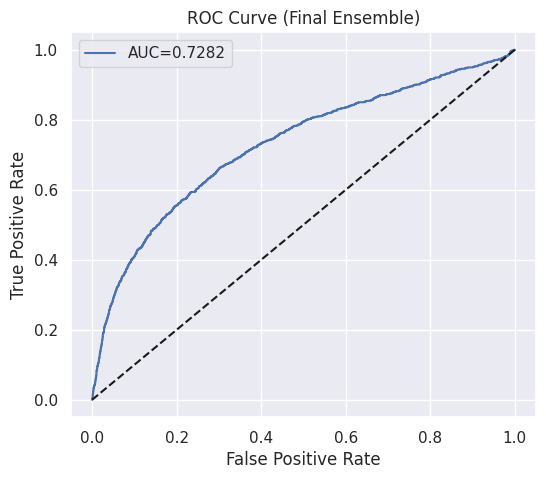

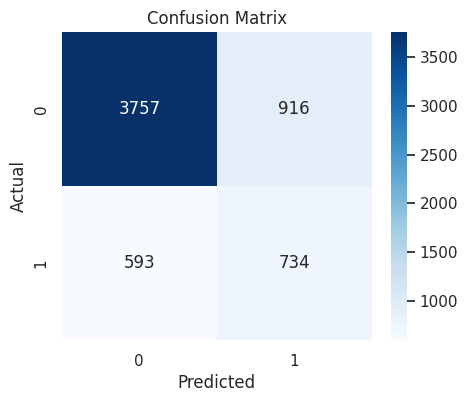


✅ Saved: lgb_model.pkl, xgb_model.pkl, stacking_meta.pkl, scaler.pkl, threshold.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 DONE! Highest accuracy model is ready.


In [16]:
fpr, tpr, _ = roc_curve(y_test, final_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, final_prob):.4f}")
plt.plot([0,1], [0,1], "k--")
plt.title("ROC Curve (Final Ensemble)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, final_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =========================================================
# 🟩 12. SAVE MODEL + SCALER + THRESHOLD
# =========================================================
import joblib
joblib.dump(lgb_model, "lgb_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(meta, "stacking_meta.pkl")
joblib.dump(scaler, "scaler.pkl")

with open("threshold.txt", "w") as f:
    f.write(str(thr))

print("\n✅ Saved: lgb_model.pkl, xgb_model.pkl, stacking_meta.pkl, scaler.pkl, threshold.txt")

# =========================================================
# 🟩 13. DOWNLOAD RESULTS
# =========================================================
files.download("lgb_model.pkl")
files.download("xgb_model.pkl")
files.download("stacking_meta.pkl")
files.download("scaler.pkl")
files.download("threshold.txt")

print("\n🎉 DONE! Highest accuracy model is ready.")
